In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# CSV dataset file name
file_name = 'D2.csv'

In [3]:
# Please put csv file in the same folder with this jupyter notebook
df_prep = pd.read_csv(file_name)

In [4]:
print(df_prep.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      20000 non-null  object
 1   gender                    20000 non-null  object
 2   age                       20000 non-null  object
 3   admission_type_id         20000 non-null  int64 
 4   discharge_disposition_id  20000 non-null  int64 
 5   admission_source_id       20000 non-null  int64 
 6   time_in_hospital          20000 non-null  int64 
 7   medical_specialty         20000 non-null  object
 8   num_lab_procedures        20000 non-null  int64 
 9   num_procedures            20000 non-null  int64 
 10  num_medications           20000 non-null  int64 
 11  number_outpatient         20000 non-null  int64 
 12  number_emergency          20000 non-null  int64 
 13  number_inpatient          20000 non-null  int64 
 14  number_diagnoses      

# Predictive modelling using Regression

# 1. Pre-processing

### a. Check Invalid values

In [5]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
def checkInvalidValue(value):
    print('**********************************')
    print(f'Checking for missing ' + value)
    for col in df_prep.columns:
        if df_prep[col].dtype == object:
            print(col,df_prep[col][df_prep[col] == value].count())

In [6]:
checkInvalidValue('?')
checkInvalidValue('NaN')
checkInvalidValue('Unknown/Invalid')


**********************************
Checking for missing ?
race 0
gender 0
age 0
medical_specialty 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
insulin 0
**********************************
Checking for missing NaN
race 0
gender 0
age 0
medical_specialty 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
insulin 0
**********************************
Checking for missing Unknown/Invalid
race 0
gender 0
age 0
medical_specialty 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
insulin 0


### b. Variables

###### Create a new collumn name medchange to record the changing in 10 drugs that have correlation to diabetes patient readmission
###### No, Steady: 0
###### Yes: 1

In [7]:
variables = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'insulin']
for col in variables:
    colname = str(col) + 'temp'
    df_prep[colname] = df_prep[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
df_prep['medchange'] = 0
for col in variables:
    colname = str(col) + 'temp'
    df_prep['medchange'] = df_prep['medchange'] + df_prep[colname]
    del df_prep[colname]
    
df_prep['medchange'].value_counts()  

0    13610
1     6085
2      279
3       26
Name: medchange, dtype: int64

Encoding some category variables to numeric values

In [8]:
df_prep['change'] = df_prep['change'].replace(True, 1)
df_prep['change'] = df_prep['change'].replace(False, 0)
df_prep['gender'] = df_prep['gender'].replace('Male', 1)
df_prep['gender'] = df_prep['gender'].replace('Female', 0)
df_prep['diabetesMed'] = df_prep['diabetesMed'].replace(True, 1)
df_prep['diabetesMed'] = df_prep['diabetesMed'].replace(False, 0)

# Medicine change
for col in variables:
    df_prep[col] = df_prep[col].replace('No', 0)
    df_prep[col] = df_prep[col].replace('Steady', 1)
    df_prep[col] = df_prep[col].replace('Up', 1)
    df_prep[col] = df_prep[col].replace('Down', 1)

Mapping values for A1Cresult, max_glu_serum to numeric values

In [9]:
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('>7', 1)
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('>8', 1)
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('Norm', 0)
df_prep['A1Cresult'] = df_prep['A1Cresult'].replace('None', -99)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('>200', 1)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('>300', 1)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('Norm', 0)
df_prep['max_glu_serum'] = df_prep['max_glu_serum'].replace('None', -99)

Age mapping

In [10]:
# mapping
age_map = {'[0-10)':1, '[10-20)':2, '[20-30)':3, '[30-40)':4, '[40-50)':5, '[50-60)':6, '[60-70)':7, '[70-80)':8, '[80-90)':9, '[90-100)':10}
#print(age_map)
df_prep['age'] = df_prep['age'].map(age_map)
print(df_prep['age'].unique())

[ 9  8  6  5  7 10  4  2  3  1]


In [11]:
# mapping
race_map = {'AfricanAmerican':1, 'Asian':2, 'Caucasian':3, 'Hispanic':4, 'Other':5}
#print(age_map)
df_prep['race'] = df_prep['race'].map(race_map)
print(df_prep['race'].unique())

[1 3 5 2 4]


Consider dropping for medical_specialty for missing a lot of information, and it may not affect to our predictive model. 
Dropping race because it doesn't help in predictive model

In [12]:
df_prep = df_prep.drop(['medical_specialty'], axis = 1)

In [13]:
df_prep.head().T

,0,1,2,3,4
race,1,3,3,1,1
gender,0,0,0,0,1
age,9,8,6,6,9
admission_type_id,1,1,3,1,1
discharge_disposition_id,3,3,1,1,3
admission_source_id,7,5,1,7,7
time_in_hospital,1,3,3,6,4
num_lab_procedures,33,48,25,41,22
num_procedures,0,2,1,0,0
num_medications,14,7,15,19,12


In [14]:
df_prep.dtypes

race                        int64
gender                      int64
age                         int64
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
number_diagnoses            int64
max_glu_serum               int64
A1Cresult                   int64
metformin                   int64
repaglinide                 int64
nateglinide                 int64
chlorpropamide              int64
glimepiride                 int64
acetohexamide               int64
glipizide                   int64
glyburide                   int64
tolbutamide                 int64
insulin                     int64
change                      int64
diabetesMed                 int64
readmitted                  int64
medchange     

In [15]:
from sklearn.model_selection import train_test_split

def data_prep(df_prep):
    # one-hot encoding
    df = pd.get_dummies(df_prep)
    
    # target/input split
    y = df['readmitted']
    X = df.drop(['readmitted'], axis=1)

    # setting random state
    rs = 10

    X_mat = X.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)
    
    return df,X,y,X_train, X_test, y_train, y_test

In [16]:
df,X,y,X_train, X_test, y_train, y_test = data_prep(df_prep)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

## 2. Build a Neural Network model using the default setting


In [18]:
from sklearn.neural_network import MLPClassifier

In [19]:
rs = 10
model_1 = MLPClassifier(random_state=rs)
model_1.fit(X_train, y_train)

print("Train accuracy:", model_1.score(X_train, y_train))
print("Test accuracy:", model_1.score(X_test, y_test))

y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_1)

Train accuracy: 0.7323571428571428
Test accuracy: 0.5983333333333334
              precision    recall  f1-score   support

           0       0.61      0.67      0.64      3203
           1       0.58      0.51      0.54      2797

    accuracy                           0.60      6000
   macro avg       0.60      0.59      0.59      6000
weighted avg       0.60      0.60      0.60      6000

MLPClassifier(random_state=10)


C:\Users\nguye\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


This default neural network performed with high accuracy on the training dataset. However, the test accuracy is comparatively much lower (59%), leading to overfitting to the training data. You should also notice a convergence warning. 

In [20]:
# model_2 = MLPClassifier(max_iter=700, random_state=rs)
# model_2.fit(X_train, y_train)

# print("Train accuracy:", model_2.score(X_train, y_train))
# print("Test accuracy:", model_2.score(X_test, y_test))

# y_pred = model_2.predict(X_test)
# print(classification_report(y_test, y_pred))

# print(model_2)

### 2a. Finding optimal hyperparameter with GridSearchCV

In [21]:
print(X_train.shape)

(14000, 29)


With 29 features, we will start tuning with one hidden layer of 5 to 29 neurons, increment of 5. This might take a bit of time. 

In [22]:
params = {'hidden_layer_sizes': [(x,) for x in range(3, 30, 3)]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(3,), (6,), (9,), (12,), (15,),
                                                (18,), (21,), (24,), (27,)]},
             return_train_score=True)

In [23]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 1.87805951,  2.34929986,  6.49918346,  8.25328393,  9.72292335,
        9.99678388, 10.14646249, 10.87013295, 10.40844841]), 'std_fit_time': array([0.19024198, 0.40035736, 1.25941015, 1.62571203, 1.99762476,
       1.14712605, 1.43526508, 0.79180072, 1.62347584]), 'mean_score_time': array([0.00104954, 0.00091338, 0.00154691, 0.00258687, 0.00136223,
       0.00268898, 0.00267394, 0.00176024, 0.00189946]), 'std_score_time': array([0.00035037, 0.00030677, 0.00056294, 0.00397526, 0.00161537,
       0.00269063, 0.00274201, 0.00225859, 0.00217217]), 'param_hidden_layer_sizes': masked_array(data=[(3,), (6,), (9,), (12,), (15,), (18,), (21,), (24,),
                   (27,)],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (3,)}, {'hidden_layer_sizes': (6,)}, {'hidden_layer_sizes': (9,)}, {'hidden_layer_sizes': (12,)}, {'hidden_laye

Plot the train and test score at split0

Total number of models:  9


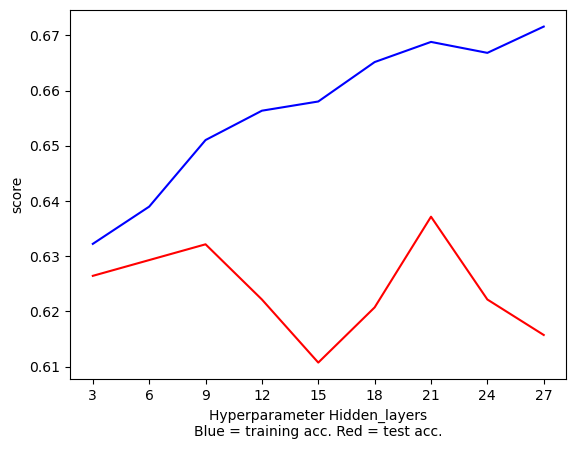

In [30]:
import matplotlib.pyplot as plt
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(3, 30, 3))
plt.ylabel('score')
plt.show()

Plot the mean train and test scores of all run

Total number of models:  9


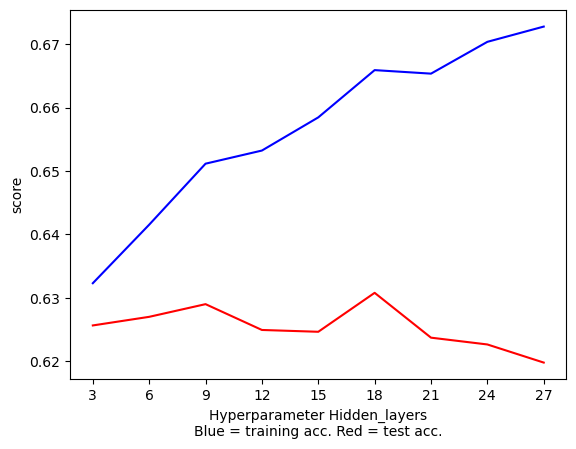

In [31]:
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(3, 30, 3))
plt.ylabel('score')
plt.show()

In [26]:
print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))

y_pred = cv_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_1.best_params_)

Train accuracy: 0.6664285714285715
Test accuracy: 0.6211666666666666
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      3203
           1       0.61      0.52      0.56      2797

    accuracy                           0.62      6000
   macro avg       0.62      0.61      0.61      6000
weighted avg       0.62      0.62      0.62      6000

{'hidden_layer_sizes': (18,)}


The output of this GridSearchCV returns 5 neurons, the default value for alpha is 0.0001, thus we will try alpha values around this number as the optimal number of neurons in the hidden layer. This model is the best model 

In [27]:
# new parameters
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]}

cv_2 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_2.fit(X_train, y_train)

print("Train accuracy:", cv_2.score(X_train, y_train))
print("Test accuracy:", cv_2.score(X_test, y_test))

y_pred = cv_2.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_2.best_params_)

Train accuracy: 0.6406428571428572
Test accuracy: 0.6268333333333334
              precision    recall  f1-score   support

           0       0.63      0.73      0.68      3203
           1       0.62      0.51      0.56      2797

    accuracy                           0.63      6000
   macro avg       0.63      0.62      0.62      6000
weighted avg       0.63      0.63      0.62      6000

{'hidden_layer_sizes': (5,)}


We now have the optimal value for neuron count in the hidden layer. Next, we will tune the second hyperparameter, alpha, which is the learning rate for the gradient descent algorithm. Larger alpha means the gradient descent will take "larger" steps and train faster, but it might miss the optimal solution. Smaller alpha results in "smaller" steps, a slower training speed yet it might stuck at the local minimum.

The default value for alpha is 0.0001, thus we will try alpha values around this number.

In [28]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_3 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_3.fit(X_train, y_train)

print("Train accuracy:", cv_3.score(X_train, y_train))
print("Test accuracy:", cv_3.score(X_test, y_test))

y_pred = cv_3.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_3.best_params_)

Train accuracy: 0.6414285714285715
Test accuracy: 0.6273333333333333
              precision    recall  f1-score   support

           0       0.63      0.73      0.68      3203
           1       0.62      0.51      0.56      2797

    accuracy                           0.63      6000
   macro avg       0.63      0.62      0.62      6000
weighted avg       0.63      0.63      0.62      6000

{'alpha': 1e-05, 'hidden_layer_sizes': (5,)}


In [29]:
# params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}
# model_2 = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=1400, random_state=rs), cv=10, n_jobs=-1)
# model_2.fit(X_train, y_train)

# print("Train accuracy:", model_2.score(X_train, y_train))
# print("Test accuracy:", model_2.score(X_test, y_test))

# y_pred = model_2.predict(X_test)
# print(classification_report(y_test, y_pred))

# print(model_2)

Train accuracy: 0.6414285714285715
Test accuracy: 0.6273333333333333
              precision    recall  f1-score   support

           0       0.63      0.73      0.68      3203
           1       0.62      0.51      0.56      2797

    accuracy                           0.63      6000
   macro avg       0.63      0.62      0.62      6000
weighted avg       0.63      0.63      0.62      6000

GridSearchCV(cv=10, estimator=MLPClassifier(max_iter=1400, random_state=10),
             n_jobs=-1,
             param_grid={'alpha': [0.01, 0.001, 0.0001, 1e-05],
                         'hidden_layer_sizes': [(3,), (5,), (7,), (9,)]})


The Neural Network model trained with  did not manage to improve model performance. Therefore, we will keep the previous best model (`cv_2`) as the best performing neural network. With 5 hidden layers, and alpha default as 0.0001

# 3. Feature selection

In [32]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train)

print(rfe.n_features_)

24


The RFE with logistic regression has selected 24 features as the best set of features. With these selected features, tune an `MLPClassifier` model.

In [33]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

#step = int((X_train_rfe.shape[1] + 5)/5)
#print(step)
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

rfe_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_rfe, y_train)

print("Train accuracy:", rfe_cv.score(X_train_rfe, y_train))
print("Test accuracy:", rfe_cv.score(X_test_rfe, y_test))

y_pred = rfe_cv.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

print(rfe_cv.best_params_)

Train accuracy: 0.6439285714285714
Test accuracy: 0.632
              precision    recall  f1-score   support

           0       0.63      0.74      0.68      3203
           1       0.63      0.51      0.57      2797

    accuracy                           0.63      6000
   macro avg       0.63      0.62      0.62      6000
weighted avg       0.63      0.63      0.63      6000

{'alpha': 1e-05, 'hidden_layer_sizes': (7,)}


This is good accuracy but selection features based on decision tree has better accuracy

### 3a. Build selection features based on decision tree (Better performance)

In [34]:
import pickle
with open('DT.pickle', 'rb') as f:
    dt_best,roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)

print(dt_best.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}


In [35]:
def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

In [36]:
analyse_feature_importance(dt_best.best_estimator_, X.columns)

number_inpatient : 0.4005671947482662
discharge_disposition_id : 0.2121816212342166
num_medications : 0.059717659342336867
number_outpatient : 0.05271418368754671
num_lab_procedures : 0.04889494148667172
number_emergency : 0.04497064071219221
age : 0.04153949690273319
number_diagnoses : 0.03706415777910682
num_procedures : 0.025511521183604283
diabetesMed : 0.024034800772124873
admission_type_id : 0.016034646171776697
admission_source_id : 0.008797298358104312
max_glu_serum : 0.007545570819704168
time_in_hospital : 0.007110015085540592
insulin : 0.005885247227054916
glimepiride : 0.0029750370656327625
race : 0.0024699323531357275
change : 0.001235889553918729
medchange : 0.0007501455163325166
A1Cresult : 0.0


In [37]:
from sklearn.feature_selection import SelectFromModel

selectmodel = SelectFromModel(dt_best.best_estimator_, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)

(14000, 8)


The decision tree model identfies the set of 8 variables as important features. Proceed to tune a MLPClassifier with this modified dataset.

In [38]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_sel_model = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))

y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv_sel_model.best_params_)

Train accuracy: 0.6404285714285715
Test accuracy: 0.6321666666666667
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      3203
           1       0.64      0.50      0.56      2797

    accuracy                           0.63      6000
   macro avg       0.63      0.62      0.62      6000
weighted avg       0.63      0.63      0.63      6000

{'alpha': 0.01, 'hidden_layer_sizes': (7,)}


# 4. Comparing the models to find the best performing model

A total of seven models has been built:
    1. Default neural network (`model_1`)
    2. Neural network with relu (`model_2`)
    3. Neural network + grid search (`cv_1`)
    4. Neural network + grid search (`cv_2`)
    5. Neural network + grid search (`cv_3`)
    6. Neural network + feature selection + grid search (`rfe_cv`)
    7. Neural network + feature selection using DT + grid search (`cv_sel_model`)
    
Now, let us use ROC curve to compare these models to identify the best performing neural network model considering both true and false positives.

In [40]:
from sklearn.metrics import roc_auc_score

y_pred_proba_nn_1 = model_1.predict_proba(X_test)
y_pred_proba_nn_2 = model_2.predict_proba(X_test)
y_pred_proba_cv_1 = cv_1.predict_proba(X_test)
y_pred_proba_cv_2 = cv_2.predict_proba(X_test)
y_pred_proba_cv_3 = cv_3.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_rfe)
y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)


roc_index_nn_1 = roc_auc_score(y_test, y_pred_proba_nn_1[:, 1])
roc_index_nn_2 = roc_auc_score(y_test, y_pred_proba_nn_2[:, 1])
roc_index_cv_1 = roc_auc_score(y_test, y_pred_proba_cv_1[:, 1])
roc_index_cv_2 = roc_auc_score(y_test, y_pred_proba_cv_2[:, 1])
roc_index_cv_3 = roc_auc_score(y_test, y_pred_proba_cv_3[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])
roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])


print("ROC index on test for NN_default:", roc_index_nn_1)
print("ROC index on test for NN with relu:", roc_index_nn_2)
print("ROC index on test for NN with gridsearch 1:", roc_index_cv_1)
print("ROC index on test for NN with gridsearch 2:", roc_index_cv_2)
print("ROC index on test for NN with gridsearch 3:", roc_index_cv_3)
print("ROC index on test for NN with feature selection and gridsearch:", roc_index_rfe_cv)
print("ROC index on test for NN with feature selection (decision tree) and gridsearch:", roc_index_cv_sel_model)

from sklearn.metrics import roc_curve

fpr_nn_1, tpr_nn_1, thresholds_nn_1 = roc_curve(y_test, y_pred_proba_nn_1[:,1])
fpr_nn_2, tpr_nn_2, thresholds_nn_2 = roc_curve(y_test, y_pred_proba_nn_2[:,1])
fpr_cv_1, tpr_cv_1, thresholds_cv_1 = roc_curve(y_test, y_pred_proba_cv_1[:,1])
fpr_cv_2, tpr_cv_2, thresholds_cv_2 = roc_curve(y_test, y_pred_proba_cv_2[:,1])
fpr_cv_3, tpr_cv_3, thresholds_cv_3 = roc_curve(y_test, y_pred_proba_cv_3[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])
fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test, y_pred_proba_cv_sel_model[:,1])

ROC index on test for NN_default: 0.6330375382124663
ROC index on test for NN with relu: 0.6657156640890495
ROC index on test for NN with gridsearch 1: 0.6623782159891887
ROC index on test for NN with gridsearch 2: 0.6655430403499758
ROC index on test for NN with gridsearch 3: 0.6657156640890495
ROC index on test for NN with feature selection and gridsearch: 0.6686336359448501
ROC index on test for NN with feature selection (decision tree) and gridsearch: 0.675160855968177


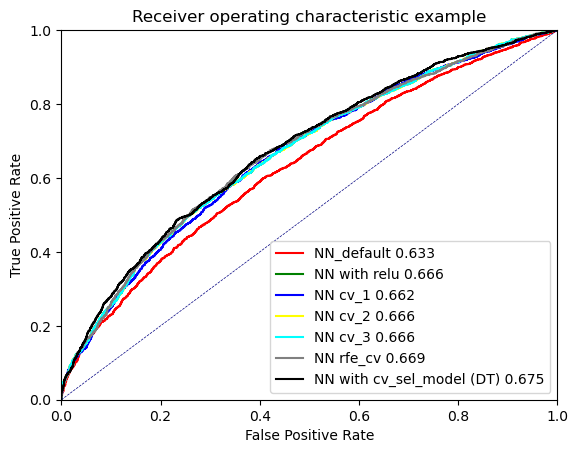

In [41]:
import matplotlib.pyplot as plt

plt.plot(fpr_nn_1, tpr_nn_1, label='NN_default {:.3f}'.format(roc_index_nn_1), color='red', lw=1.5)
plt.plot(fpr_nn_2, tpr_nn_2, label='NN with relu {:.3f}'.format(roc_index_nn_2), color='green', lw=1.5)
plt.plot(fpr_cv_1, tpr_cv_1, label='NN cv_1 {:.3f}'.format(roc_index_cv_1), color='blue', lw=1.5)
plt.plot(fpr_cv_2, tpr_cv_2, label='NN cv_2 {:.3f}'.format(roc_index_cv_2), color='yellow', lw=1.5)
plt.plot(fpr_cv_3, tpr_cv_3, label='NN cv_3 {:.3f}'.format(roc_index_cv_3), color='cyan', lw=1.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='NN rfe_cv {:.3f}'.format(roc_index_rfe_cv), color='gray', lw=1.5)
plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model (DT) {:.3f}'.format(roc_index_cv_sel_model), color='black', lw=1.5)


plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [46]:
import pickle
nn_best = cv_sel_model
roc_index_nn_best = roc_index_cv_sel_model
tpr_nn_best = tpr_cv_sel_model
fpr_nn_best = fpr_cv_sel_model
with open('NN.pickle', 'wb') as f:
    pickle.dump([nn_best,roc_index_nn_best, fpr_nn_best, tpr_nn_best], f)

# 5. ROC for all the best model (not use that, for investigate only)

In [ ]:
with open('DT.pickle', 'rb') as f:
    dt_best,roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)

print(dt_best.best_params_)


with open('LR.pickle', 'rb') as f:
    dt_lr_best,roc_index_dt_lr_cv, fpr_dt_lr_cv, tpr_dt_lr_cv = pickle.load(f)

print(dt_lr_best.best_params_)

In [ ]:
def analyse_feature_importance_lr(dm_model, feature_names, n_to_display=30):
    # grab feature importances from the model
    importances = dm_model.best_estimator_.coef_[0]
    
    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)

    # limit to 30 features, you can leave this out to print out everything
    indices = indices[:n_to_display]

    for i in indices:
        print(feature_names[i], ':', importances[i])

In [ ]:
analyse_feature_importance(dt_best.best_estimator_, X.columns)

In [ ]:
analyse_feature_importance_lr(dt_lr_best, X.columns)

In [ ]:
from sklearn.feature_selection import SelectFromModel

selectmodel_lr = SelectFromModel(dt_lr_best.best_estimator_, prefit=True)
X_train_sel_model_lr = selectmodel_lr.transform(X_train)
X_test_sel_model_lr = selectmodel_lr.transform(X_test)

print(X_train_sel_model_lr.shape)

In [ ]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_sel_model_lr = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_sel_model_lr.fit(X_train_sel_model_lr, y_train)

print("Train accuracy:", cv_sel_model_lr.score(X_train_sel_model_lr, y_train))
print("Test accuracy:", cv_sel_model_lr.score(X_test_sel_model_lr, y_test))

y_pred = cv_sel_model_lr.predict(X_test_sel_model_lr)
print(classification_report(y_test, y_pred))

print(cv_sel_model.best_params_)

ROC base on decision tree and logistic regression optimize models

In [ ]:
y_pred_proba_cv_sel_model = cv_sel_model.predict_proba(X_test_sel_model)
y_pred_proba_lr = rfe_cv.predict_proba(X_test_rfe)

roc_index_cv_sel_model = roc_auc_score(y_test, y_pred_proba_cv_sel_model[:, 1])
roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])

print("ROC index on test for NN with feature selection (decision tree model selection) and gridsearch:", roc_index_cv_sel_model)
print("ROC index on test for NN with logistic regression with default:", roc_index_lr)

from sklearn.metrics import roc_curve

fpr_cv_sel_model, tpr_cv_sel_model, thresholds_cv_sel_model = roc_curve(y_test, y_pred_proba_cv_sel_model[:,1])
fpr_rfe_lr, tpr_rfe_lr, thresholds_rfe_lr = roc_curve(y_test, y_pred_proba_lr[:,1])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr_cv_sel_model, tpr_cv_sel_model, label='NN with cv_sel_model (DT) {:.3f}'.format(roc_index_cv_sel_model), color='red', lw=1.5)
plt.plot(fpr_rfe_lr, tpr_rfe_lr, label='NN logistic regression {:.3f}'.format(roc_index_lr), color='green', lw=1.5)


plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Ensemble Modeling

In [42]:
# import the model
from sklearn.ensemble import VotingClassifier

# load the best performing decision tree and logistic regression models that we have saved from last two pracs
import pickle
with open('DT.pickle', 'rb') as f:
    dt_best,roc_index_dt, fpr_dt, tpr_dt = pickle.load(f)
with open('LR.pickle', 'rb') as f:
    lr_best,roc_index_lr, fpr_lr, tpr_lr = pickle.load(f)
with open('NN.pickle', 'rb') as f:
    nn_best,roc_index_nn, fpr_nn, tpr_nn = pickle.load(f)   

# select the best performing neural network
nn_best = cv_sel_model

# initialise the classifier with 3 different estimators
voting = VotingClassifier(estimators=[('dt', dt_best), ('lr', lr_best), ('nn', nn_best)], voting='soft')

In [43]:
# fit the voting classifier to training data
voting.fit(X_train, y_train)

# evaluate train and test accuracy
print("Ensemble train accuracy:", voting.score(X_train, y_train))
print("Ensemble test accuracy:", voting.score(X_test, y_test))

# evaluate ROC auc score
y_pred_proba_ensemble = voting.predict_proba(X_test)
roc_index_ensemble = roc_auc_score(y_test, y_pred_proba_ensemble[:, 1])
print("ROC score of voting classifier:", roc_index_ensemble)

Ensemble train accuracy: 0.6557857142857143
Ensemble test accuracy: 0.6368333333333334
ROC score of voting classifier: 0.6796182654556848


# ROC

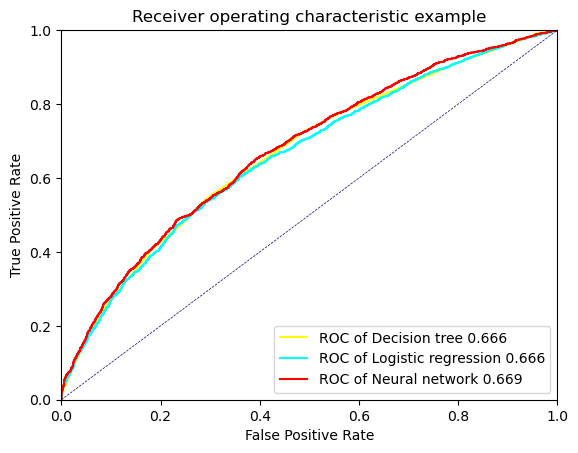

In [45]:
plt.plot(fpr_dt, tpr_dt, label='ROC of Decision tree {:.3f}'.format(roc_index_cv_2), color='yellow', lw=1.5)
plt.plot(fpr_lr, tpr_lr, label='ROC of Logistic regression {:.3f}'.format(roc_index_cv_3), color='cyan', lw=1.5)
plt.plot(fpr_nn, tpr_nn, label='ROC of Neural network {:.3f}'.format(roc_index_rfe_cv), color='red', lw=1.5)


plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()